# Predicting Personality: Introverts vs. Extroverts using Behavioral Data

## Abstract

This project uses machine learning to classify individuals as introverts or extroverts based on behavioral and social indicators. It explores feature engineering, model optimization, and explainability using SHAP and built-in importances to uncover what drives personality classification.

---

## Problem Statement

**Goal:**  
To build a predictive model that accurately classifies whether a person is an introvert or extrovert based on behavioral and lifestyle features.

**Why it matters:**  
Understanding personality through behavior can provide insights into social preferences, mental health, and engagement styles. This has applications in HR, product design, education, and social platforms.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('personality_dataset.csv')

# Preprocessing

## Dataset Overview

- **Observations:** ~2900 rows  
- **Features:** ~9 behavioral features including social activity, isolation, and self-reported preferences  
- **Target variable:** Personality label (`Introvert`, `Extrovert`)  
- **Missing data:** Some columns had missing values; handled via imputation (see below)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [4]:
data.isnull().sum()

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64

In [5]:
from sklearn.impute import SimpleImputer

numeric_features = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency']

cat_features = [
    'Drained_after_socializing',
    'Stage_fear',]

# Create imputers for numeric and binary features making sure that no missing values are dropped
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
data[numeric_features] = num_imputer.fit_transform(data[numeric_features])
data[cat_features] = cat_imputer.fit_transform(data[cat_features])

data.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [6]:
#Check for duplicates
duplicates = data[data.duplicated()]
duplicates.count()

Time_spent_Alone             448
Stage_fear                   448
Social_event_attendance      448
Going_outside                448
Drained_after_socializing    448
Friends_circle_size          448
Post_frequency               448
Personality                  448
dtype: int64

In [7]:
print(duplicates.head(10))

     Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
47               10.0        Yes                      1.0            2.0   
217               5.0        Yes                      2.0            0.0   
246               9.0        Yes                      0.0            1.0   
248               9.0        Yes                      0.0            2.0   
254               7.0        Yes                      0.0            0.0   
258               4.0        Yes                      2.0            0.0   
261               8.0        Yes                      2.0            2.0   
264               8.0        Yes                      2.0            1.0   
267               4.0        Yes                      0.0            1.0   
283               7.0        Yes                      1.0            1.0   

    Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
47                        Yes                  2.0             0.0   Introvert  
2

But in this case, out of 2900 people, there ought to be some people with the same statistics.

So as long as they have the same personality output, it's still correct. 

# Exploration

In [8]:
data.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.494828,3.942759,3.000000,6.235172,3.552069
std,3.441971,2.875987,2.221597,4.237255,2.894794
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.000000,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [9]:
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


Text(0.5, 1.0, 'Boxplot of Time Spent Alone')

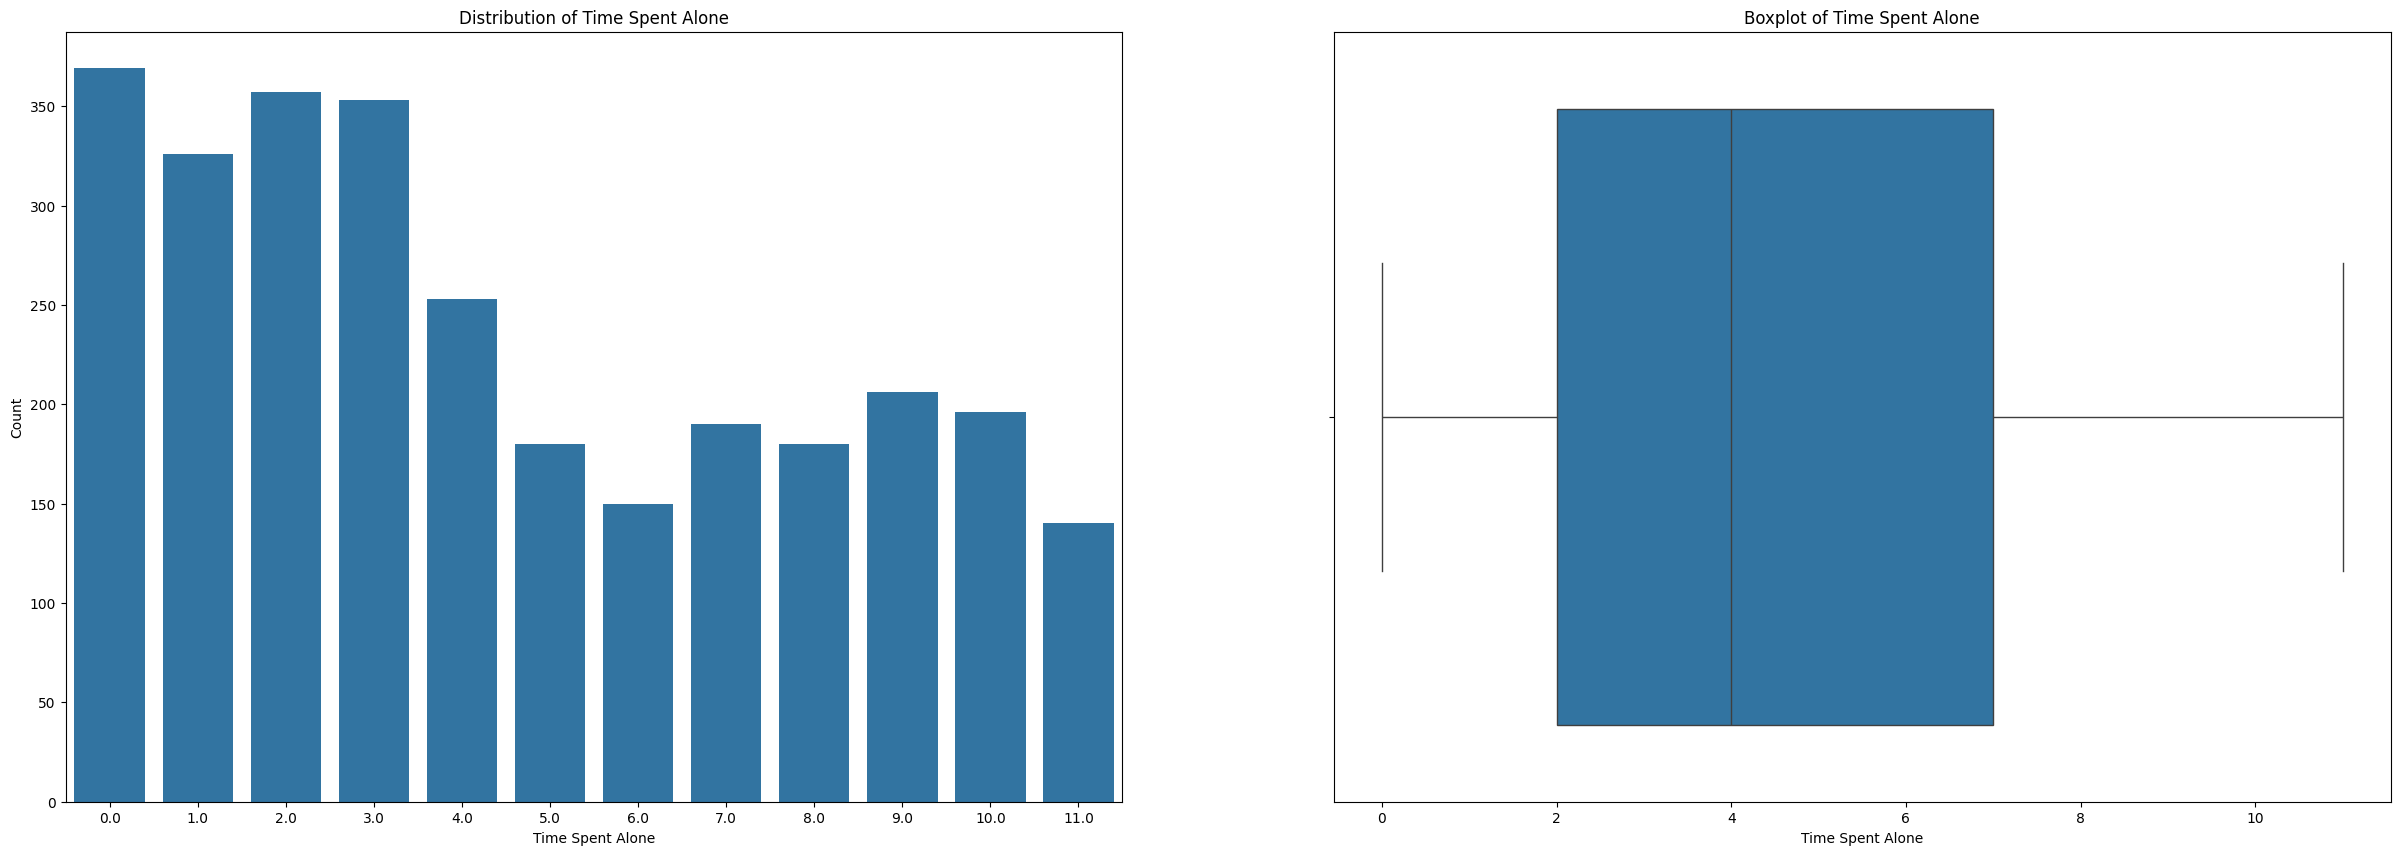

In [10]:
# data['Time_spent_Alone'] = data['Time_spent_Alone'].round()

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(data=data, x='Time_spent_Alone', ax=axes[0])
axes[0].set_xlabel('Time Spent Alone')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Time Spent Alone')

sns.boxplot(data=data, x='Time_spent_Alone', ax=axes[1])
axes[1].set_xlabel('Time Spent Alone')
axes[1].set_title('Boxplot of Time Spent Alone')

- Most people spend 2 to 7 hours alone.
- With the most amount of people spending 0-2 hour alone and least amount of people spending 11 hours alone. 
- The amount of people spending more time alone decreases, with the least being 11 hours.
- The median is 4 hours so the typical person spend 4 hours alone a day. 

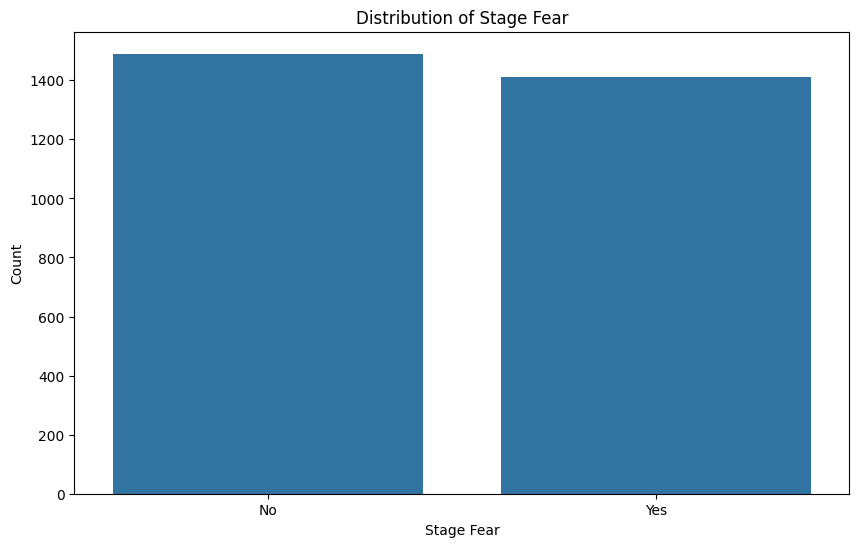

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x=data['Stage_fear'])
plt.title('Distribution of Stage Fear')
plt.xlabel('Stage Fear')
plt.ylabel('Count')
plt.show()

In [12]:
print(data['Stage_fear'].value_counts())

Stage_fear
No     1490
Yes    1410
Name: count, dtype: int64


More people have Stage fear than not. 

Text(0.5, 1.0, 'Boxplot of Social_event_attendance')

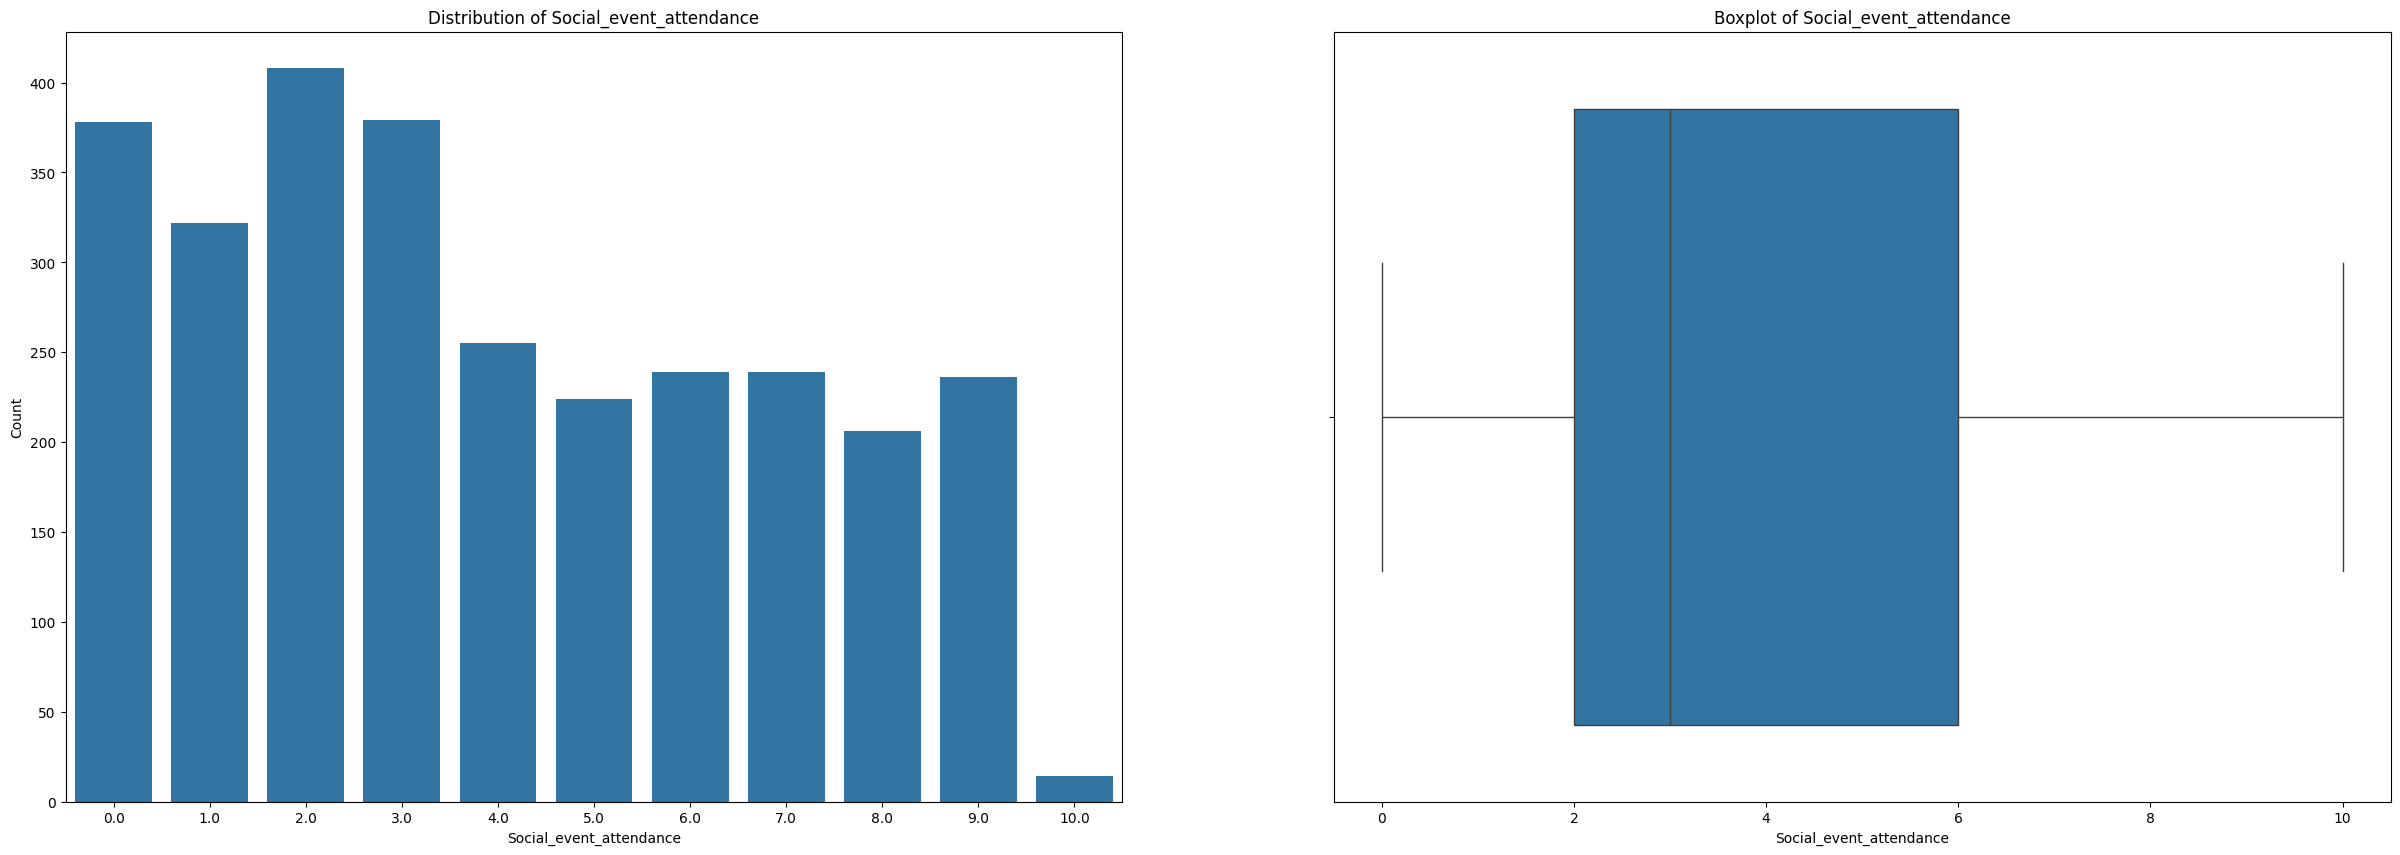

In [13]:
# data['Social_event_attendance'] = data['Social_event_attendance'].round()
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(data=data, x='Social_event_attendance', ax=axes[0])
axes[0].set_xlabel('Social_event_attendance')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Social_event_attendance')

sns.boxplot(data=data, x='Social_event_attendance', ax=axes[1])
axes[1].set_xlabel('Social_event_attendance')
axes[1].set_title('Boxplot of Social_event_attendance')

- Most people attend 2 social events a week which makes sense due to the fact that most work a 5-day-week. 
- Less than around 15 out of 2900 people attend 10 events. 
- The majority of people attend from 0 to 4 events.
- The median is 3 events. 

Text(0.5, 1.0, 'Boxplot of Going_outside')

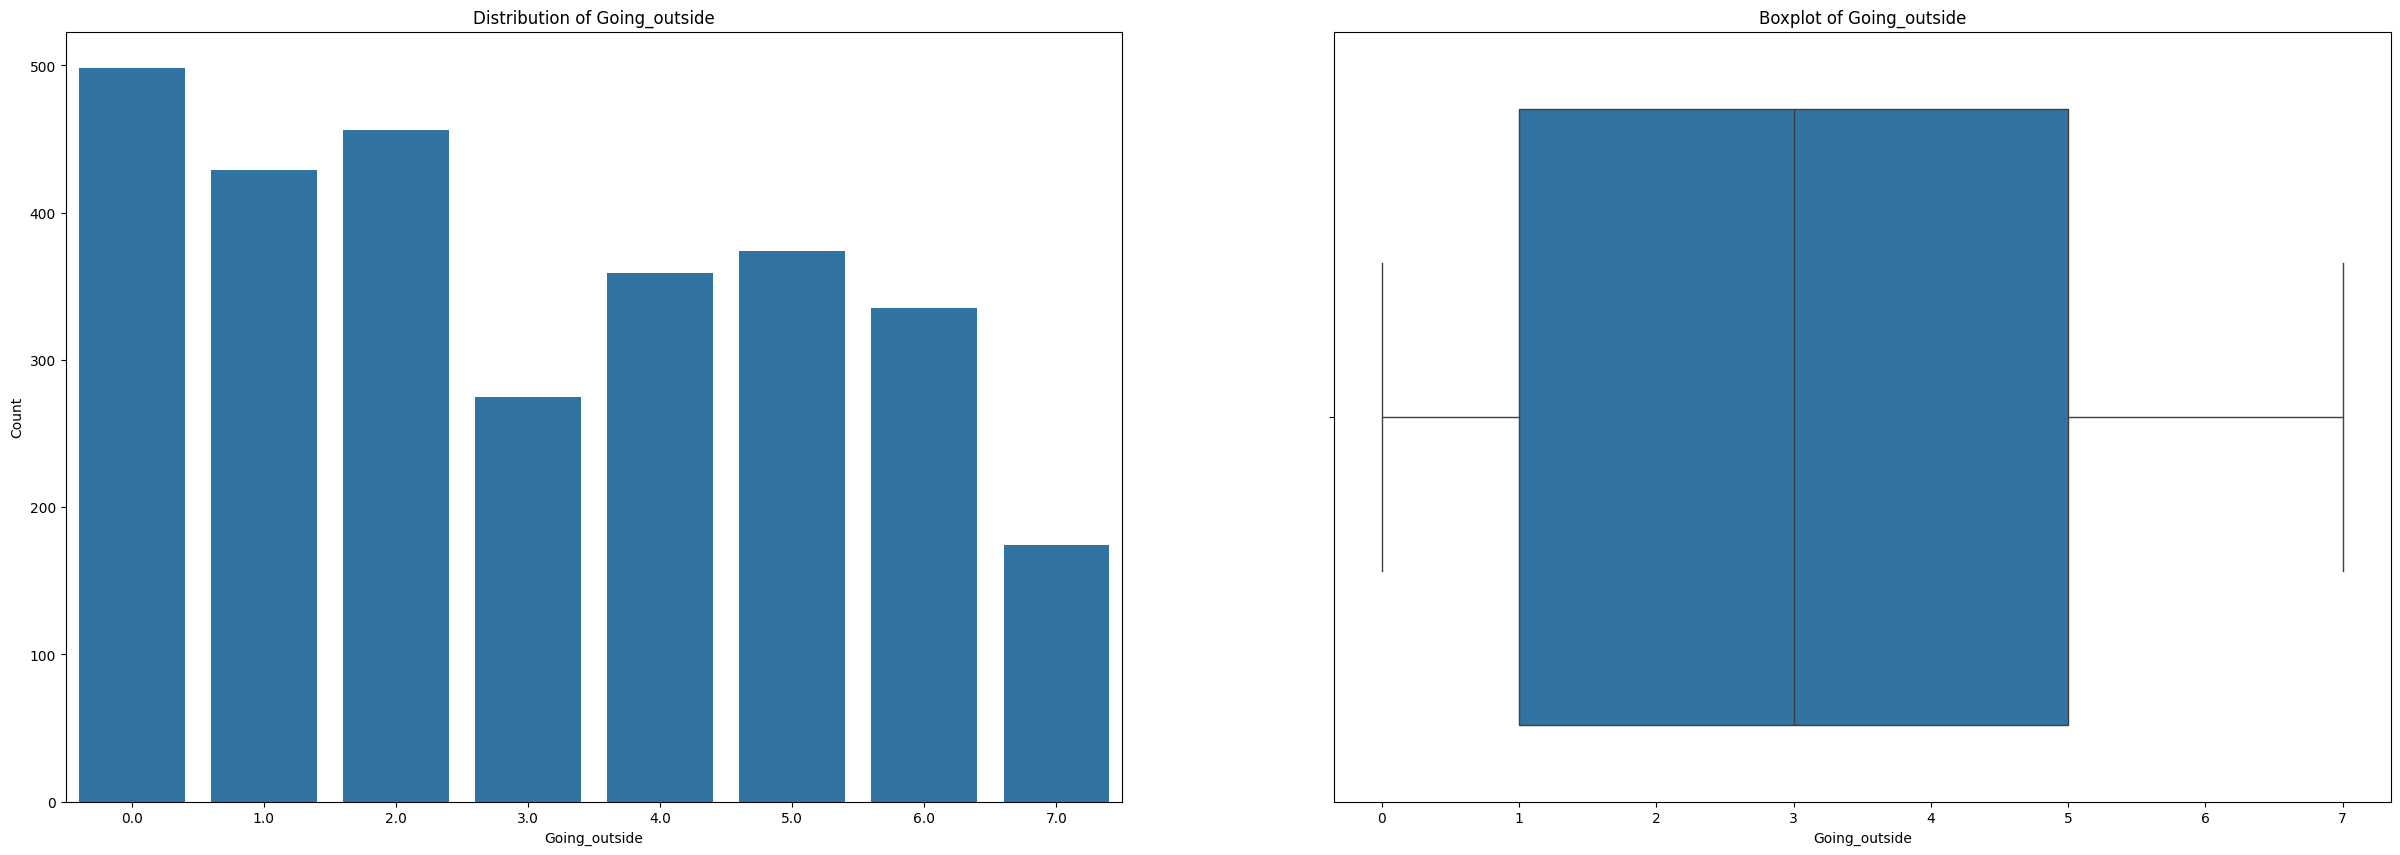

In [14]:
# data['Going_outside'] = data['Going_outside'].round()
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(data=data, x='Going_outside', ax=axes[0])
axes[0].set_xlabel('Going_outside')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Going_outside')

sns.boxplot(data=data, x='Going_outside', ax=axes[1])
axes[1].set_xlabel('Going_outside')
axes[1].set_title('Boxplot of Going_outside')

- Most people spend 0 to 2 hours outside 
- The median is 3 hours
- From 4 to 6 hours there are less and less people.

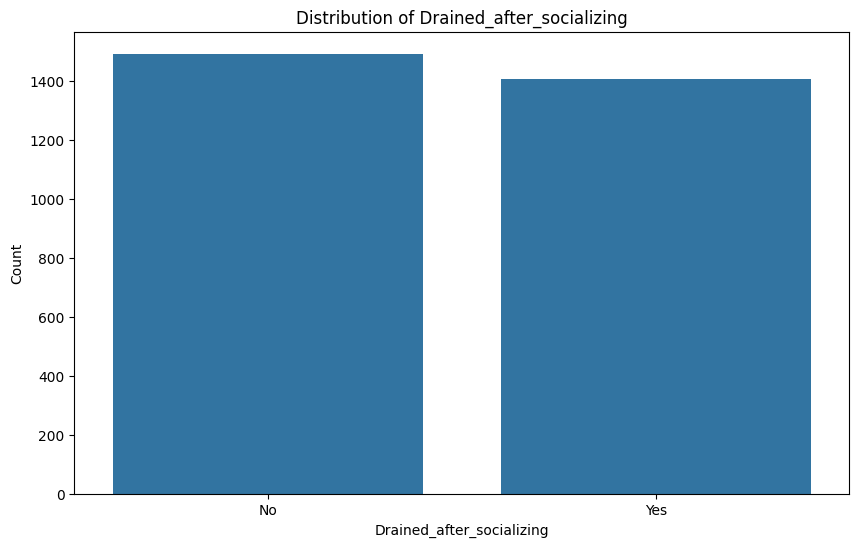

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x=data['Drained_after_socializing'])
plt.title('Distribution of Drained_after_socializing')
plt.xlabel('Drained_after_socializing')
plt.ylabel('Count')
plt.show()

In [16]:
print(data['Drained_after_socializing'].value_counts())

Drained_after_socializing
No     1493
Yes    1407
Name: count, dtype: int64


- Similar to stage fear, more people are drained after socialising.

Text(0.5, 1.0, 'Boxplot of Friends_circle_size')

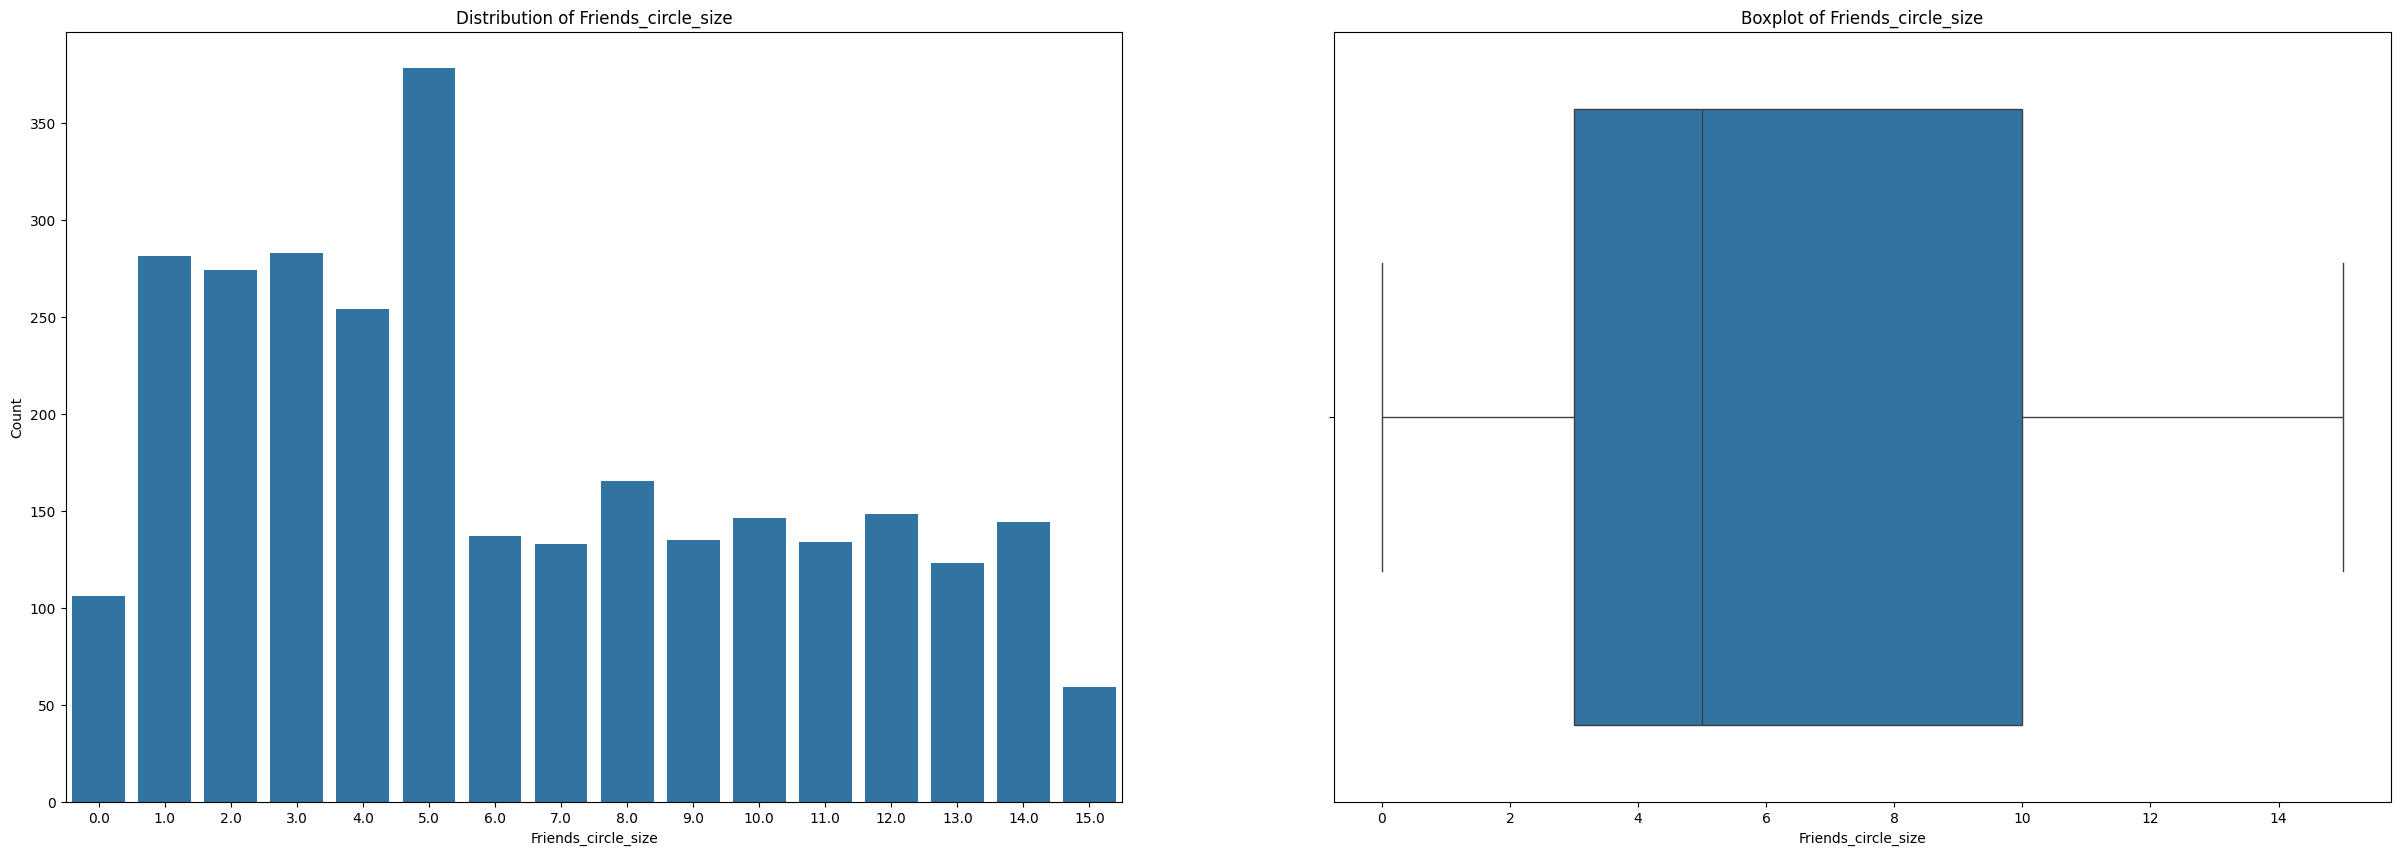

In [17]:
# data['Friends_circle_size'] = data['Friends_circle_size'].round()

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(data=data, x='Friends_circle_size', ax=axes[0])
axes[0].set_xlabel('Friends_circle_size')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Friends_circle_size')

sns.boxplot(data=data, x='Friends_circle_size', ax=axes[1])
axes[1].set_xlabel('Friends_circle_size')
axes[1].set_title('Boxplot of Friends_circle_size')

- Most have from 1 to 5 friends in there circle. 
- There are only a few with no one in their circle and even less with 15 friends. 
- The median is 5 friends, meaning the typical person would have 5 in their circle.

Text(0.5, 1.0, 'Boxplot of Post_frequency')

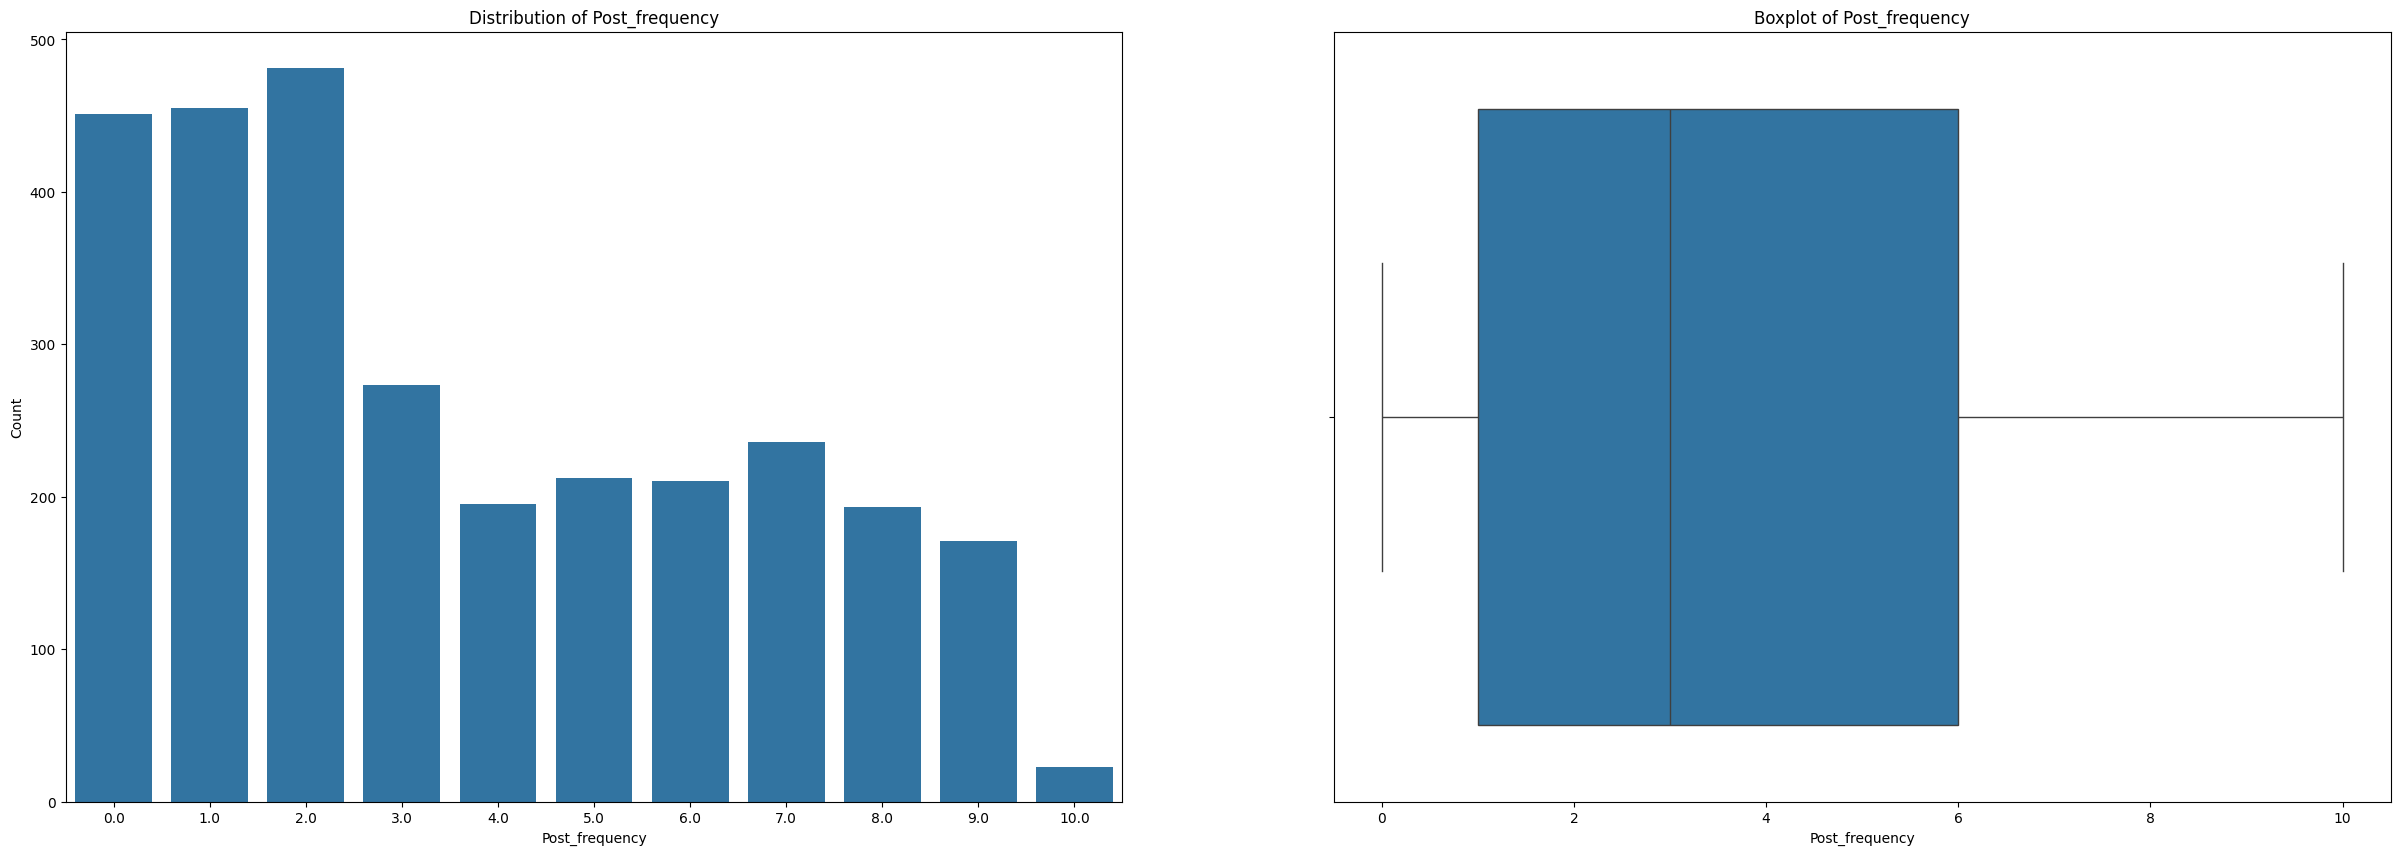

In [18]:
# data['Post_frequency'] = data['Post_frequency'].round()

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(data=data, x='Post_frequency', ax=axes[0])
axes[0].set_xlabel('Post_frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Post_frequency')

sns.boxplot(data=data, x='Post_frequency', ax=axes[1])
axes[1].set_xlabel('Post_frequency')
axes[1].set_title('Boxplot of Post_frequency')

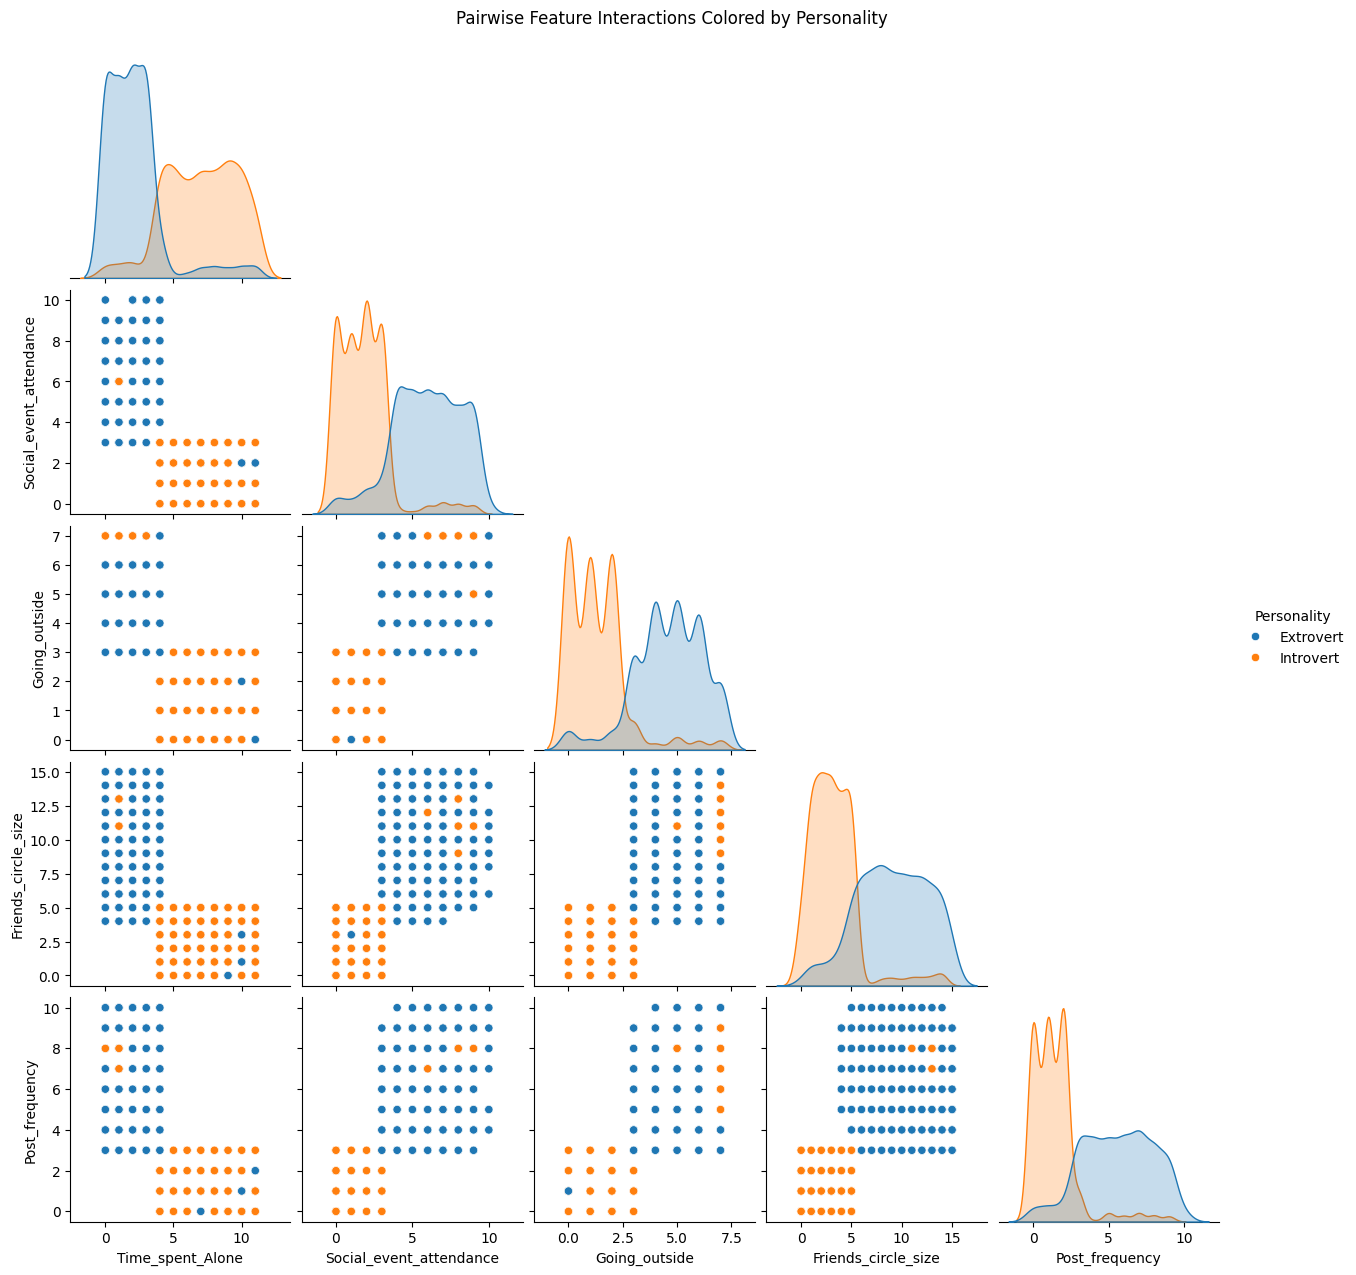

In [19]:
pairplot_data = data[numeric_features + ['Personality']]

# Step 3: Plot
sns.pairplot(pairplot_data, hue='Personality', corner=True)
plt.suptitle('Pairwise Feature Interactions Colored by Personality', y=1.02)
plt.show()


- We can see a specific segmentation of introverts and extroverts for each variables. 

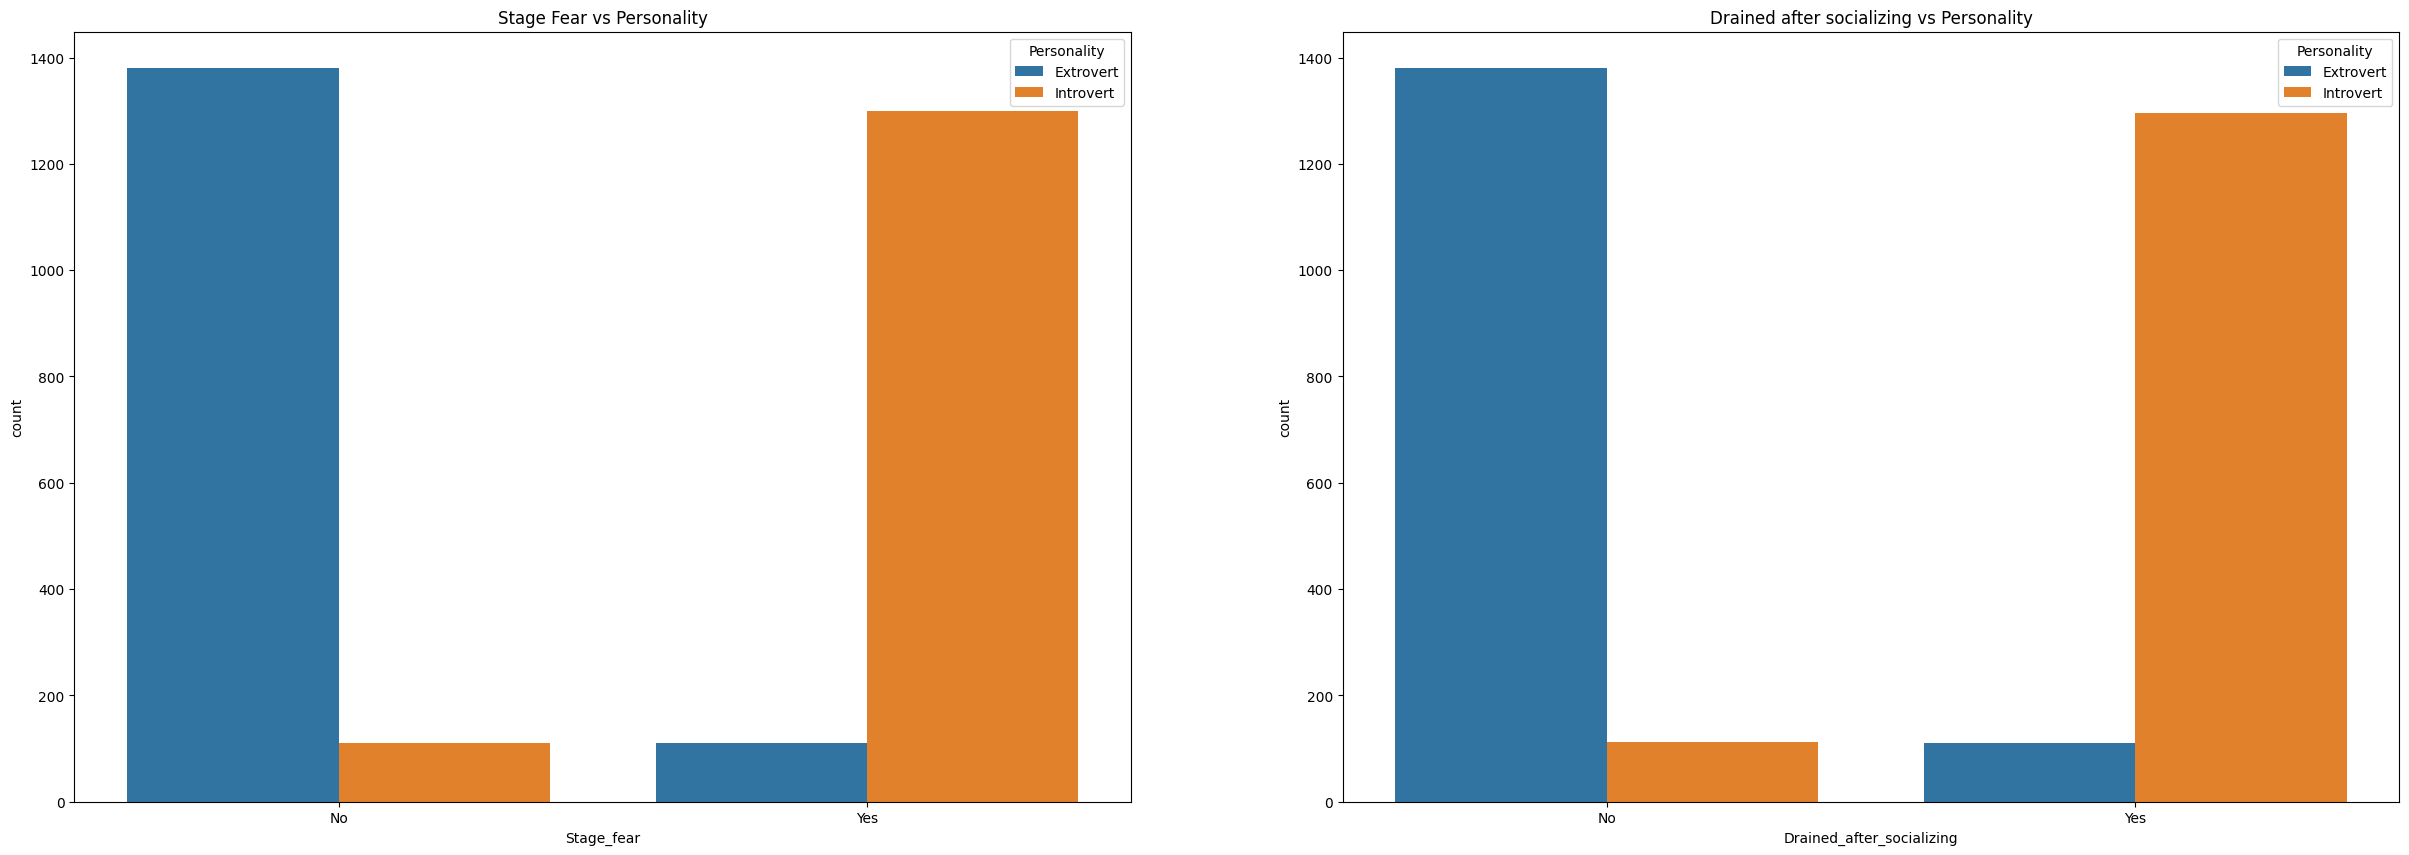

Personality  Extrovert  Introvert
Stage_fear                       
No            0.926174   0.073826
Yes           0.078723   0.921277
******************************
Personality                Extrovert  Introvert
Drained_after_socializing                      
No                          0.924313   0.075687
Yes                         0.078891   0.921109


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.countplot(x='Stage_fear', hue='Personality', data=data, ax=axes[0])
axes[0].set_title("Stage Fear vs Personality")

sns.countplot(x='Drained_after_socializing', hue='Personality', data=data, ax=axes[1])
axes[1].set_title("Drained after socializing vs Personality")
plt.show()

# Or use a crosstab
print(pd.crosstab(data['Stage_fear'], data['Personality'], normalize='index'))
print('*'*30)
print(pd.crosstab(data['Drained_after_socializing'], data['Personality'], normalize='index'))


- We can clearly see that extroverts are less likely to have stage freight and be drained after socialising, and vice versa

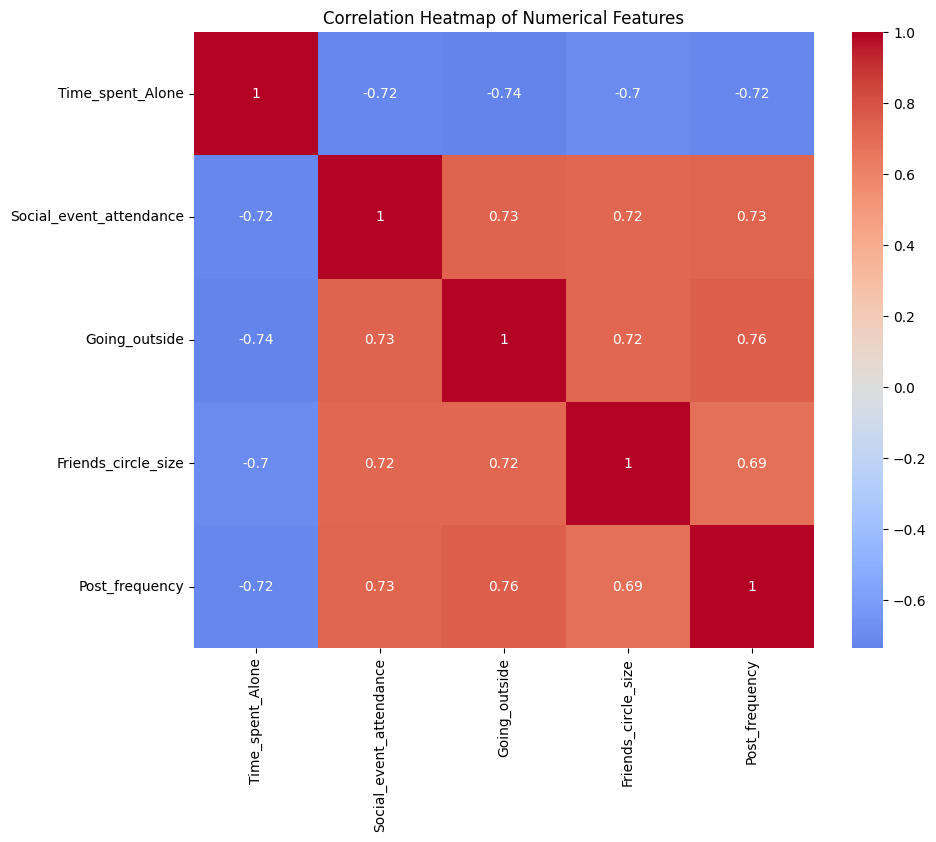

In [21]:
#Heat map for numerical data
corr = data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

- Most features are very correlated. 
- Only Time_spent_Alone has a negative correlation.

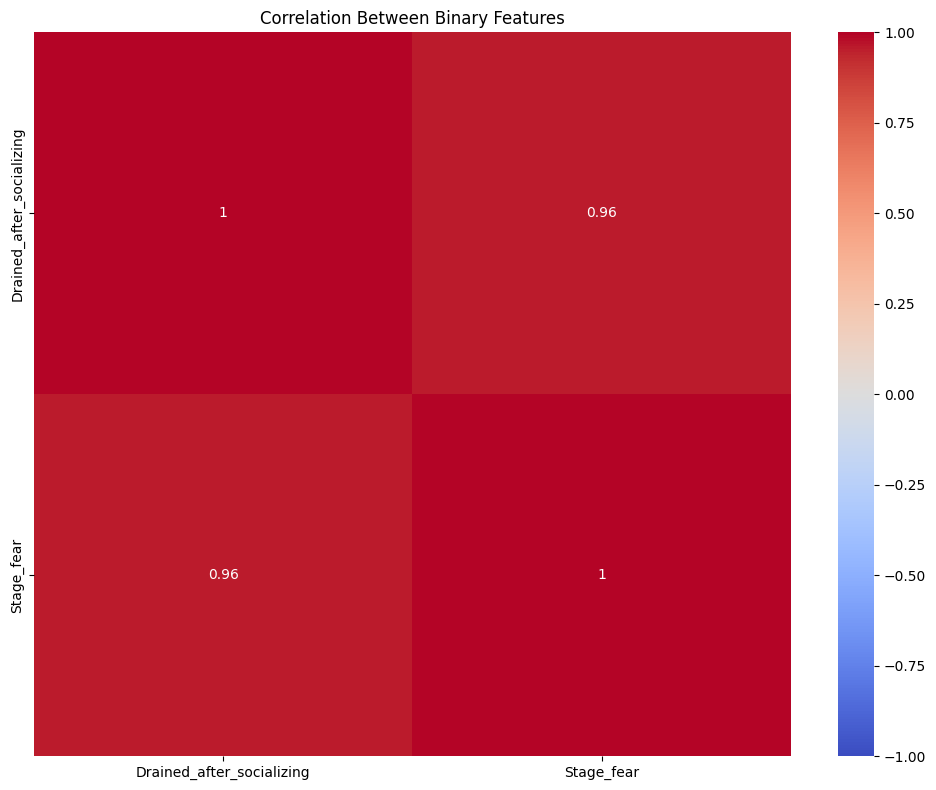

In [22]:
data[cat_features] = data[cat_features].replace({'Yes': 1, 'No': 0})

binary_corr_matrix = data[cat_features].corr()

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(binary_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Binary Features")
plt.tight_layout()
plt.show()

- The 2 binary features are highly correlated. 

# Feature engineering

### Feature Engineering
- `Social_Comfort_Index`: Combined measure based on social activity and self-reported comfort
- `Alone_to_Social_Ratio`: Ratio of time spent alone to social attendance
- `Social_Fatigue`: Derived from "Drained after socializing" to capture energy dynamics

### Transformations
- Scaled numerical features using `MinMaxScaler`
- Encoded categorical features using `OrdinalEncoder` or `OneHotEncoder`


In [23]:
# The ratio of alone time to social event attendance
data['Alone_to_Social_ratio'] = data['Time_spent_Alone'] / (data['Social_event_attendance'])
data['Alone_to_Social_ratio'] = data['Alone_to_Social_ratio'].replace([np.inf, -np.inf], np.nan)
data['Alone_to_Social_ratio'] = data['Alone_to_Social_ratio'].fillna(data['Alone_to_Social_ratio'].median())

# The index score of social comfort, measuring how comfortable a person is in social situations
data['Social_comfort_index'] = (data['Social_event_attendance'] + data['Going_outside'] + data['Stage_fear']) / 3


# Train/test split

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np

X = data.drop(columns=['Personality'])
y = data['Personality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 2320
Test set size: 580


# Modeling
## Model Building & Evaluation

### Models Used
- Logistic Regression
- Decision Tree
- Random Forest (with hyperparameter tuning via `RandomizedSearchCV`)
- CatBoost Classifier

### Evaluation Metrics
- Accuracy
- F1 Score (macro average)
- Confusion Matrix

### Cross-Validation
- Performed 5-fold cross-validation on all models
- Best estimator chosen based on highest macro F1 on validation set

## Logistic Reg

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Identify categorical columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

X_train_encoded[cat_features] = encoder.fit_transform(X_train[cat_features])
X_test_encoded[cat_features] = encoder.transform(X_test[cat_features])

# Fit logistic regression on encoded data
model = LogisticRegression()
model.fit(X_train_encoded, y_train)

# Predict and evaluate
y_pred_logreg = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.92


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define transformers
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)])

# Build pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))])

# Example param grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10]}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'model__max_depth': 5, 'model__n_estimators': 100}
Best Score: 0.9357758620689655


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Best model from grid search
best_model_logre = grid_search.best_estimator_
y_pred_logre = best_model_logre.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_logre))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_logre))

print(f"\nF1 Score on Test Set (macro): {f1_score(y_test, y_pred_logre, average='macro'):.5f}")



Classification Report (Test Set):
              precision    recall  f1-score   support

   Extrovert       0.94      0.92      0.93       302
   Introvert       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580


Confusion Matrix (Test Set):
[[278  24]
 [ 17 261]]

F1 Score on Test Set (macro): 0.92925


## Decision tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Fit decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_encoded, y_train)

y_dt_pred = tree.predict(X_test_encoded)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_dt_pred))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_dt_pred))

print(f"F1 score on validation set - macro: {f1_score(y_test, y_dt_pred, average='macro'):.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

   Extrovert       0.88      0.87      0.87       302
   Introvert       0.86      0.87      0.86       278

    accuracy                           0.87       580
   macro avg       0.87      0.87      0.87       580
weighted avg       0.87      0.87      0.87       580


Confusion Matrix (Test Set):
[[262  40]
 [ 37 241]]
F1 score on validation set - macro: 0.8671


In [29]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder

param_dist_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Let's assume 'Extrovert' is the positive class — change if needed
custom_f1 = make_scorer(f1_score, pos_label='Extrovert')

random_search = RandomizedSearchCV(
    tree,
    param_distributions=param_dist_tree,
    n_iter=20,
    cv=5,
    scoring=custom_f1,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

final_dc = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [30]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict on test set
y_dc_best_pred = final_dc.predict(X_test)

# Evaluate on test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_dc_best_pred))


print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_dc_best_pred))

print(f"F1 score on validation set - macro: {f1_score(y_test, y_dc_best_pred, average='macro'):.5f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

   Extrovert       0.94      0.92      0.93       302
   Introvert       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580


Confusion Matrix (Test Set):
[[278  24]
 [ 17 261]]
F1 score on validation set - macro: 0.92925


## Random forest
### Unregularised

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train model
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_rf_test_pred = rf_pipeline.predict(X_test)

print('Classification report (Test set:)')
print(classification_report(y_test, y_rf_test_pred))

print("Confusion Matrix (Test set):")
print(confusion_matrix(y_test, y_rf_test_pred))

print(f"F1 score on validation set - macro: {f1_score(y_test, y_rf_test_pred, average='macro'):.5f}")

Classification report (Test set:)
              precision    recall  f1-score   support

   Extrovert       0.93      0.91      0.92       302
   Introvert       0.91      0.92      0.92       278

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Confusion Matrix (Test set):
[[276  26]
 [ 21 257]]
F1 score on validation set - macro: 0.91888


### Regularised

In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    scoring=custom_f1,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

final_rf_op = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [33]:
# Predict with the best tree
y_rf_best_pred = final_rf_op.predict(X_test)

# Evaluate
print('Classification report (Test set):')
print(classification_report(y_test, y_rf_best_pred))

print('Confusion Matrix (Test set):')
print(confusion_matrix(y_test, y_rf_best_pred))

print(f"F1 score on validation set - macro: {f1_score(y_test, y_rf_best_pred, average='macro'):.4f}")

Classification report (Test set):
              precision    recall  f1-score   support

   Extrovert       0.94      0.92      0.93       302
   Introvert       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580

Confusion Matrix (Test set):
[[278  24]
 [ 17 261]]
F1 score on validation set - macro: 0.9292


## Catboost

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline with Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the model
gb_model = gb_pipeline.fit(X_train, y_train)


In [35]:
y_pred_gb = gb_model.predict(X_test)

# Evaluate
print('Classification report (Test set):')
print(classification_report(y_test, y_pred_gb))

print('Confusion matrix (Test set):')
print(confusion_matrix(y_test, y_pred_gb))

print(f"F1 score on validation set - macro: {f1_score(y_test, y_pred_gb, average='macro'):.5f}")

Classification report (Test set):
              precision    recall  f1-score   support

   Extrovert       0.94      0.92      0.93       302
   Introvert       0.92      0.94      0.93       278

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580

Confusion matrix (Test set):
[[278  24]
 [ 18 260]]
F1 score on validation set - macro: 0.92752


In [36]:
# Dictionary of model names and their F1 scores
f1_scores = {
    "Logistic Regression": f1_score(y_test, y_pred_logre, average='macro'),
    "Decision Tree": f1_score(y_test, y_dc_best_pred, average='macro'),
    "Random Forest": f1_score(y_test, y_rf_test_pred, average='macro'),
    "Random Forest (Tuned)": f1_score(y_test, y_rf_best_pred, average='macro'),
    "CatBoost": f1_score(y_test, y_pred_gb, average='macro')
}

df_scores = pd.DataFrame(f1_scores.items(), columns=["Model", "F1 Score (Macro)"])
df_scores_sorted = df_scores.sort_values(by="F1 Score (Macro)", ascending=False).reset_index(drop=True)

# Display
print(df_scores_sorted)


                   Model  F1 Score (Macro)
0    Logistic Regression          0.929250
1          Decision Tree          0.929250
2  Random Forest (Tuned)          0.929250
3               CatBoost          0.927516
4          Random Forest          0.918878


# Feature importance

In [37]:
importances = final_rf_op.feature_importances_
feature_names = X_train.columns  

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importance_df)


                     Feature  Importance
0       Social_comfort_index    0.268546
1                 Stage_fear    0.252021
2  Drained_after_socializing    0.154058
3    Social_event_attendance    0.125869
4           Time_spent_Alone    0.096341
5              Going_outside    0.071427
6             Post_frequency    0.019486
7        Friends_circle_size    0.007782
8      Alone_to_Social_ratio    0.004470


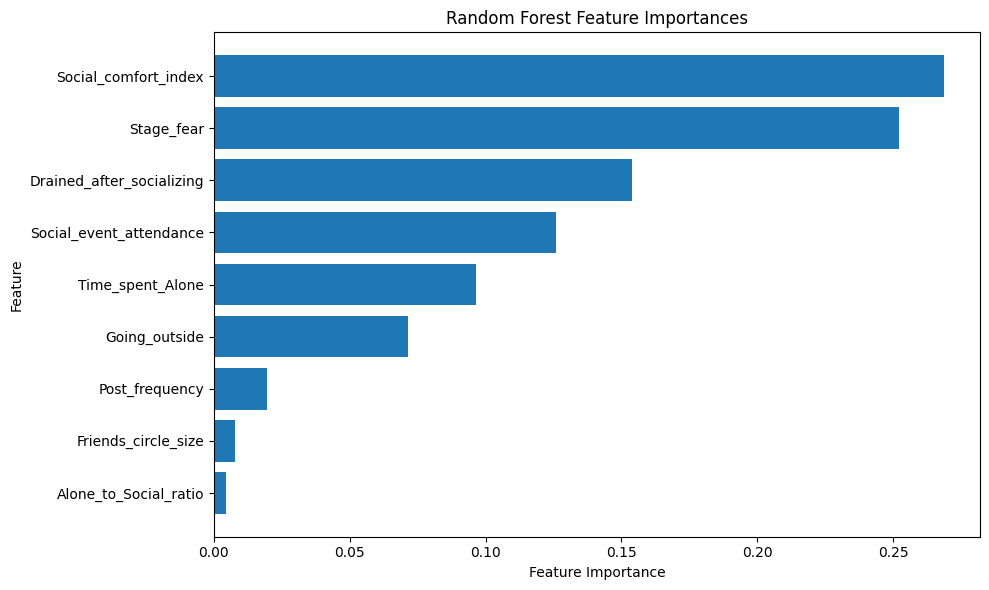

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


- The social comfort index (new feature) is the most important feature, providing nearly 27% of the classification decisions. 
- Stage fear is also a big contributor, which makes sense since most extroverts are more comfortable with public speaking.
- The model is able to be 93% accurate with the validation data, providing a high level of accuracy.